In [4]:
from nltk.corpus import wordnet as wn
from fastai.basics import *
import nmslib
import pdb
from collections import defaultdict
from sklearn.metrics import average_precision_score
from fastprogress import master_bar, progress_bar
from multiprocessing import Process
import matplotlib.pyplot as plt
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [5]:
edges = set()
queue = [(wn.synset("mammal.n.01"),0)]
node_strength = defaultdict(int)
levels = {}
while queue:
    n,level = queue.pop(0)
    levels[n.name()] = level
    nh = 0
    for hypo in n.closure(lambda s: s.hyponyms()):
        edges.add((hypo.name(),n.name()))
        queue.append((hypo,level+1))
        nh += 1
    node_strength[n.name()] = nh

In [6]:
vocab = list({n for edge in edges for n in edge})
stoi = {s:i for i,s in enumerate(vocab)}
adj = defaultdict(set)
for a,b in edges: adj[stoi[a]].add(stoi[b])
negs = {}
for w in vocab:
    negs[w] = [stoi[x] for x in vocab if (w,x) not in edges]

In [7]:
def euclidean_distance(u,v):
    return torch.sum((u-v)**2,dim=-1)

In [8]:
eps = 1e-5
boundary = 1 - eps
class PoincareDistance(torch.autograd.Function):

    @staticmethod
    def grad(x, v, sqnormx, sqnormv, sqdist):
        alpha = (1 - sqnormx)
        beta = (1 - sqnormv)
        z = 1 + 2 * sqdist / (alpha * beta)
        a = ((sqnormv - 2 * torch.sum(x * v, dim=-1) + 1) / torch.pow(alpha, 2))
        a = a.unsqueeze(-1) * x - v / alpha.unsqueeze(-1)
        z = torch.sqrt(torch.pow(z, 2) - 1)
        z = torch.clamp(z * beta, min=eps)
        return 4 * a / z.unsqueeze(-1)
    
    @staticmethod
    def forward(self, u, v):
        self.save_for_backward(u, v)
        self.squnorm = torch.clamp(torch.sum(u * u, dim=-1), 0, boundary)
        self.sqvnorm = torch.clamp(torch.sum(v * v, dim=-1), 0, boundary)
        self.sqdist = torch.sum(torch.pow(u - v, 2), dim=-1)
        x = self.sqdist / ((1 - self.squnorm) * (1 - self.sqvnorm)) * 2 + 1
        # arcosh
        z = torch.sqrt(torch.pow(x, 2) - 1)
        return torch.log(x + z)
    
    @staticmethod
    def backward(self, g):
        u, v = self.saved_tensors
        g = g.unsqueeze(-1)
        gu = PoincareDistance.grad(u, v, self.squnorm, self.sqvnorm, self.sqdist)
        gv = PoincareDistance.grad(v, u, self.sqvnorm, self.squnorm, self.sqdist)
        return g.expand_as(gu) * gu, g.expand_as(gv) * gv

In [9]:
class WNDataset(Dataset):
    def __init__(self,edges,vocab,negs):
        self.edges = edges
        self.vocab = vocab
        self.negs = negs
        self.items = [1,2,3]
        
    def __len__(self): return len(self.edges)
    
    def __getitem__(self,idx):
        a,b = self.edges[idx]
        #neg = torch.randint(0,len(vocab),(11,))
        #neg[0] = stoi[b]
        neg = np.zeros(11,dtype=np.int)
        neg[0] = stoi[b]
        neg[1:] = np.random.choice(self.negs[a],10,replace=False)
        return (stoi[a],neg),0

In [10]:
wnDS = WNDataset(list(edges),vocab,negs)
valDS = WNDataset(list(edges)[:100],vocab,negs)
db = DataBunch.create(wnDS,valDS,bs=32,num_workers=0)

In [11]:
class SimpleWN(torch.nn.Module):
    def __init__(self,vocabSize,embSize):
        super().__init__()
        self.emb = torch.nn.Embedding(vocabSize,embSize,sparse=True,max_norm=1.0)
        with torch.no_grad(): trunc_normal_(self.emb.weight, std=0.01)
        
    def forward(self,w,v):
        #pdb.set_trace()
        w = self.emb(w)
        v = self.emb(v.long())
        d = (w.unsqueeze(1)-v)**2
        return -d.sum(dim=2)

In [12]:
class EuclideanEmbedding(torch.nn.Module):
    def __init__(self,embSize,embDim):
        super().__init__()
        self.emb = torch.nn.Embedding(embSize,embDim,sparse=True,max_norm=1.0)
        with torch.no_grad(): trunc_normal_(self.emb.weight, std=0.01)
            
    def forward(self,x):
        return self.emb(x)

In [13]:
class PoincareEmbedding(torch.nn.Module):
    def __init__(self,embSize,embDim):
        super().__init__()
        self.emb = torch.nn.Embedding(embSize,embDim,sparse=True,max_norm=1.0)
        def poincareGrad(d_p):
            p = self.emb.weight
            p_sqnorm = torch.sum(
                p.data[d_p._indices()[0].squeeze()] ** 2, dim=1,
                keepdim=True
            ).expand_as(d_p._values())
            n_vals = d_p._values() * ((1 - p_sqnorm) ** 2) / 4
            d_p = torch.sparse.FloatTensor(d_p._indices(), n_vals, d_p.size())
            return d_p
        self.emb.weight.register_hook(poincareGrad)
        
        #with torch.no_grad(): trunc_normal_(self.emb.weight, std=0.01)
        with torch.no_grad(): self.emb.weight.uniform_(-0.001,0.001)
        
    def forward(self,x):
        return self.emb(x)

In [14]:
#dist_fn = poincare_distance
dist_fn = PoincareDistance.apply
#dist_fn = euclidean_distance
class PoincareWN(torch.nn.Module):
    def __init__(self,vocabSize,embSize):
        super().__init__()
        self.emb = PoincareEmbedding(vocabSize,embSize)
        #self.emb = EuclideanEmbedding(vocabSize,embSize)
        
    def forward(self,w,v):
        w = self.emb(w)
        v = self.emb(v.long())
        d = dist_fn(w.unsqueeze(1),v)
        return -d

In [15]:
def mean_average_precision(adj,emb,pb=True):
    ap = []
    with torch.no_grad():
        a = adj
        if pb: a = progress_bar(a)
        for n,na in a:
            dists = dist_fn(emb[n].unsqueeze(0),emb)
            dists[n] = 1e12
            dists = dists.cpu().numpy()
            labels = np.zeros(emb.size(0))
            labels[list(na)] = 1
            ap.append(average_precision_score(labels,-dists))
    return np.mean(ap)

In [16]:
class MapMetric(Callback):
    def on_epoch_end(self, **kwargs):
        self.metric = mean_average_precision(adj.items(),learn.model.emb.emb.weight,pb=False)

In [17]:
model = PoincareWN(len(vocab),2)
learn = Learner(db,model,loss_func=torch.nn.functional.cross_entropy,opt_func=torch.optim.SparseAdam,metrics=[MapMetric()])

In [18]:
x,y = next(iter(db.train_dl))
model(*x).size()

torch.Size([32, 11])

In [ ]:
learn.lr_find(num_it=100)
learn.recorder.plot()

In [21]:
#learn.fit_one_cycle(10,1e-4,wd=0)
learn.fit(50,1e-2,wd=0)

epoch,train_loss,valid_loss,map_metric
1,1.641844,1.572638,0.086965
2,1.566328,1.515998,0.089583
3,1.517909,1.445874,0.094522
4,1.490645,1.402313,0.095020
5,1.415220,1.309456,0.095303
6,1.348823,1.296289,0.096224
7,1.337677,1.275861,0.098036
8,1.292049,1.205673,0.098518
9,1.252224,1.285331,0.098145
10,1.233589,1.185912,0.101228


AxesSubplot(0.125,0.125;0.775x0.755)


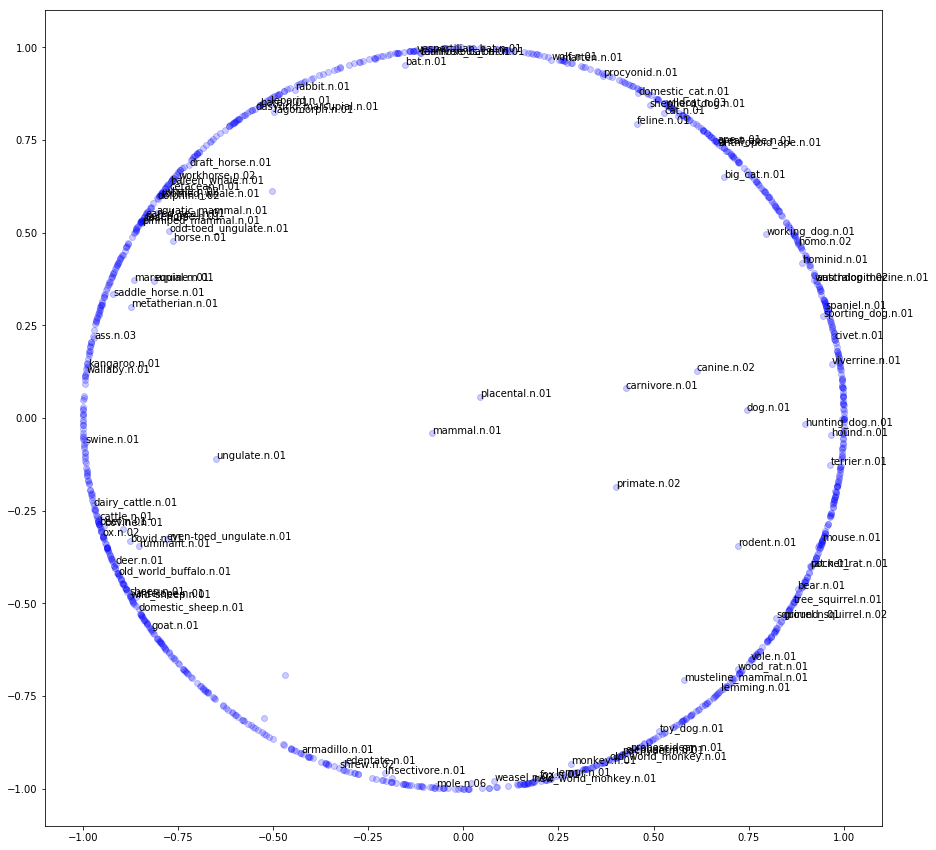

In [29]:
weights = learn.model.emb.emb.weight.cpu().detach().numpy()
#weights = gsemb
fig,ax = plt.subplots(figsize=(15,15))
print(ax)
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
for i,(x,y) in enumerate(weights):
    ax.plot(x,y,marker="o",color=(0,0,1,0.2))
    if node_strength[vocab[i]] > 5:
    #if levels[vocab[i]] < 3:
        ax.annotate(vocab[i],(x,y))
# for a,b in dedges:
#     x1,y1 = weights[stoi[a]]
#     x2,y2 = weights[stoi[b]]
#     ax.plot([x1,x2],[y1,y2],color=(0,0,1,0.1))

In [23]:
dists = dist_fn(torch.zeros(1,learn.model.emb.emb.weight.size()[1],dtype=torch.float).cuda(),learn.model.emb.emb.weight)
[vocab[i] for i in dists.argsort()[:10]]

['placental.n.01',
 'mammal.n.01',
 'carnivore.n.01',
 'primate.n.02',
 'canine.n.02',
 'ungulate.n.01',
 'dog.n.01',
 'black-footed_ferret.n.01',
 'rodent.n.01',
 'capuchin.n.02']

In [24]:
def knn(i,k,emb):
    dists = dist_fn(emb[i].unsqueeze(0),emb)
    return dists.argsort()[:k]

In [25]:
for i in knn(stoi["silverback.n.01"],8,learn.model.emb.emb.weight): print(vocab[i])

silverback.n.01
gorilla.n.01
jird.n.01
big_cat.n.01
feline.n.01
cat.n.01
wild_dog.n.01
shepherd_dog.n.01


In [26]:
for j in np.random.choice(len(vocab),5,replace=False):
    for i in knn(j,8,learn.model.emb.emb.weight): print(vocab[i])
    print("")

nonstarter.n.02
flying_phalanger.n.01
black-footed_ferret.n.01
horse.n.01
lagomorph.n.01
draft_horse.n.01
odd-toed_ungulate.n.01
equine.n.01

central_chimpanzee.n.01
procyonid.n.01
feline.n.01
snow_leopard.n.01
shepherd_dog.n.01
domestic_cat.n.01
cat.n.01
placental.n.01

pointer.n.04
sporting_dog.n.01
retriever.n.01
dugong.n.01
canine.n.02
dog.n.01
spaniel.n.01
viverrine.n.01

nilgai.n.01
dairy_cattle.n.01
canada_porcupine.n.01
goat_antelope.n.01
even-toed_ungulate.n.01
bovid.n.01
ruminant.n.01
cattle.n.01

guenon.n.01
toy_dog.n.01
musteline_mammal.n.01
english_toy_spaniel.n.01
hog-nosed_skunk.n.01
proboscidean.n.01
ermine.n.02
primate.n.02

